Things to do
- Get AIF datasets
- Train on positive pairs for fairness
- Generate synthetic testing pairs
- Evaluate fairness
- Code up a booster

In [ ]:
!pip install git+https://github.com/clabrugere/pytorch-scarf.git
!pip install aif360
!pip install tqdm
!pip install pandas
!pip install scikit-learn
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

In [93]:
# Imports
from scarf.loss import NTXent
from scarf.model import SCARF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from tqdm import tqdm
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder
from aif360.sklearn.datasets import fetch_adult, fetch_lawschool_gpa, fetch_compas
from sklearn.preprocessing import MinMaxScaler

In [94]:
class SCARFDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    @property
    def features_low(self):
        return self.data.min(axis=0)

    @property
    def features_high(self):
        return self.data.max(axis=0)

    @property
    def shape(self):
        return self.data.shape

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [162]:
# Hyperparameters & Helper Functions
def dataset_embeddings(model, loader, device):
    embeddings = []

    for x in tqdm(loader):
        x = x.to(device)
        embeddings.append(model.get_embeddings(x))

    embeddings = torch.cat(embeddings).cpu().numpy()

    return embeddings


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


batch_size = 128
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1234
fix_seed(seed)
protected_indices = [0, 1]
protected = ["race", "gender"]

In [163]:
dataset = "lawschool"  # Either compas, lawschool, or adult
if dataset == "adult":
    X, y, _ = fetch_adult()
    X.index = y.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
    y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)
    X = pd.get_dummies(X, prefix_sep="__", drop_first=True)
    X = X.reset_index()
    y = y.reset_index()
    X.fillna(0, inplace=True)
    train_data, test_data, train_target, test_target = train_test_split(
        X, y, train_size=16281, shuffle=False)
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)

elif dataset == "lawschool":
    train_data, train_target = fetch_lawschool_gpa("train", numeric_only=True)
    test_data, test_target = fetch_lawschool_gpa("test", numeric_only=True)
    scaler = MinMaxScaler()
    train_data = pd.DataFrame(
        scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index
    )
    test_data = pd.DataFrame(
        scaler.transform(test_data), columns=test_data.columns, index=test_data.index
    )
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)

elif dataset == "compas":
    cols = ["sex", "race", "age_cat", "priors_count", "c_charge_degree"]
    X, y = fetch_compas(usecols=cols, binary_race=True)

    # Quantize priors count between 0, 1-3, and >3
    X["priors_count"] = pd.cut(
        X["priors_count"], [-1, 0, 3, 100], labels=["0", "1 to 3", "More than 3"]
    )
    X_test, X_train, y_test, y_train = train_test_split(
        X, y, test_size=3694, shuffle=True, random_state=0
    )

else:
    print("Error! Dataset not found.")
    
train_ds = SCARFDataset(train_data.to_numpy().astype(float), train_target.to_numpy(), columns=train_data.columns)
test_ds = SCARFDataset(test_data.to_numpy().astype(float), test_data.to_numpy(), columns=test_data.columns)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Train set: (14969, 4)
Test set: (7373, 4)


In [164]:
# Model
model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = NTXent()

In [165]:
# Training for accuracy
loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        emb_anchor, emb_positive = model(x)

        loss = criterion(emb_anchor, emb_positive)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")

epoch 10/500 - loss: 611.0715
epoch 20/500 - loss: 607.0331
epoch 30/500 - loss: 605.0245
epoch 40/500 - loss: 603.5632
epoch 50/500 - loss: 601.9445
epoch 60/500 - loss: 602.4034
epoch 70/500 - loss: 601.3867
epoch 80/500 - loss: 601.5366
epoch 90/500 - loss: 600.5483
epoch 100/500 - loss: 600.4936
epoch 110/500 - loss: 600.0431
epoch 120/500 - loss: 600.1357
epoch 130/500 - loss: 601.1296
epoch 140/500 - loss: 600.9156
epoch 150/500 - loss: 600.6283
epoch 160/500 - loss: 600.6764
epoch 170/500 - loss: 600.2398
epoch 180/500 - loss: 599.8613
epoch 190/500 - loss: 600.9188
epoch 200/500 - loss: 600.1025
epoch 210/500 - loss: 599.2932
epoch 220/500 - loss: 599.5977
epoch 230/500 - loss: 599.6668
epoch 240/500 - loss: 600.1222
epoch 250/500 - loss: 599.3934
epoch 260/500 - loss: 598.5902
epoch 270/500 - loss: 599.1023
epoch 280/500 - loss: 599.3771
epoch 290/500 - loss: 598.2188
epoch 300/500 - loss: 598.5408
epoch 310/500 - loss: 599.1048
epoch 320/500 - loss: 598.8184
epoch 330/500 - l

In [168]:
# Train for fairness
loss_history_fair = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        x_copy = x.clone()

        for row_idx in range(x_copy.size(0)):
            for idx in protected_indices:
                x_copy[row_idx, idx] = 1 - x_copy[row_idx, idx]

        emb_x, _ = model(x)
        emb_x_copy, _ = model(x_copy)
        loss = criterion(emb_x, emb_x_copy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history_fair.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history_fair[-1]:.4f}")

epoch 10/500 - loss: 597.4307
epoch 20/500 - loss: 597.4307
epoch 30/500 - loss: 597.4307
epoch 40/500 - loss: 597.4307
epoch 50/500 - loss: 597.4307
epoch 60/500 - loss: 597.4307
epoch 70/500 - loss: 597.4307
epoch 80/500 - loss: 597.4307
epoch 90/500 - loss: 597.4307


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

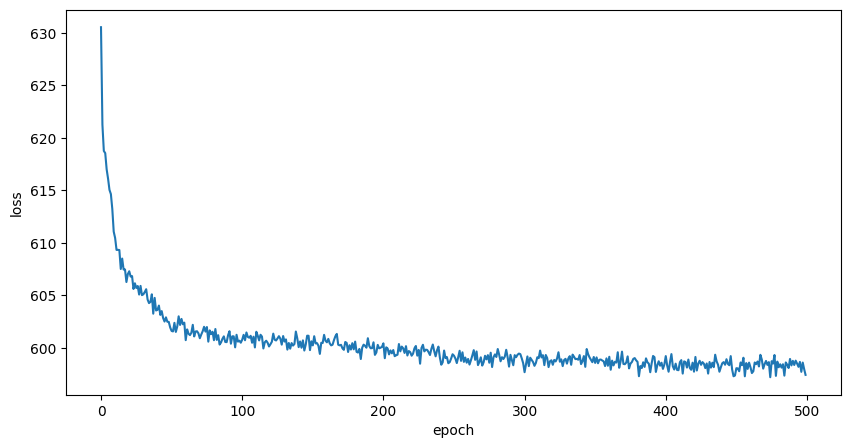

In [169]:
# Plot loss history of regular training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

Text(0, 0.5, 'loss')

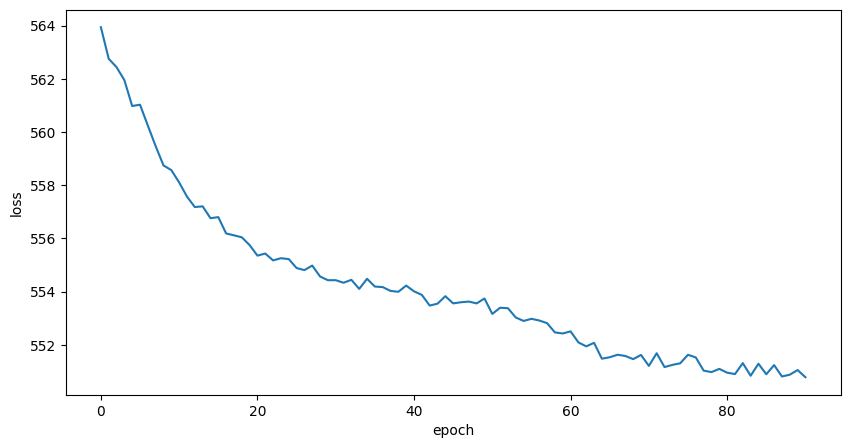

In [170]:
# Plot loss history of fairness training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history_fair)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [171]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 58/58 [00:00<00:00, 368.78it/s]

(14969, 8)
(7373, 8)


In [172]:
clf_vanilla = LogisticRegression()
# vanilla dataset: train the classifier on the original data
clf_vanilla.fit(train_data, train_target)
vanilla_predictions = clf_vanilla.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     21741
           1       0.71      0.22      0.34      7200

    accuracy                           0.78     28941
   macro avg       0.75      0.60      0.61     28941
weighted avg       0.77      0.78      0.74     28941



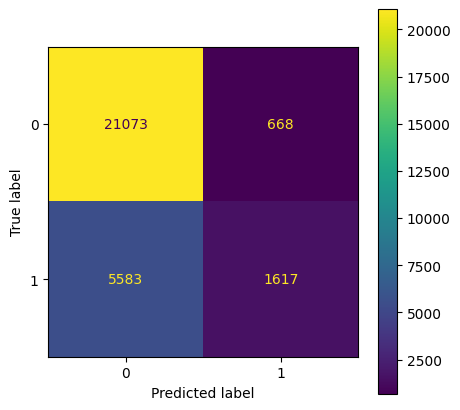

In [138]:
# embeddings dataset: train the classifier on the embeddings
clf = LogisticRegression()
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

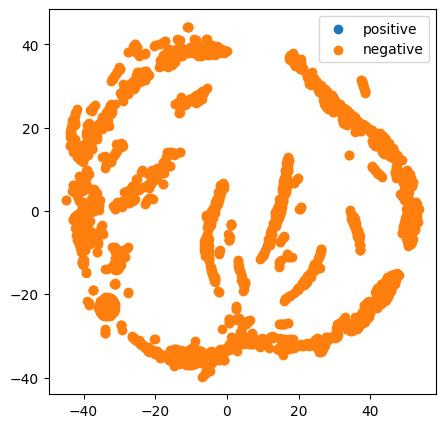

In [173]:
#Visualizing the embeddings with T-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings[:2000])
positive = train_target[:2000] == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

In [149]:
# Generate synthetic Data for fairness testing
print(train_data.dtypes.unique())
def generate_synthetic_data(df):
    synthetic_data = {}
    for column in df.columns:
        if df[column].dtype in ["int64", "float64", "int8"]:
            min_value = df[column].min()
            max_value = df[column].max()
            synthetic_data[column] = np.random.uniform(
                min_value, max_value, size=len(df)
            )
        elif df[column].dtype == "object":
            unique_values = df[column].unique()
            synthetic_data[column] = np.random.choice(unique_values, size=len(df))
        elif df[column].dtype == "bool":
            synthetic_data[column] = np.random.choice([True, False], size=len(df))
        else:
            synthetic_data[column] = [np.nan] * len(df)

    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
    return synthetic_df

fairness_test_df = generate_synthetic_data(train_data)
fairness_test_ds = SCARFDataset(
    fairness_test_df.to_numpy().astype(float),
    train_target.to_numpy(),
    columns=fairness_test_df.columns,
)  # The other 2 columns don't really matter

fairness_test_loader = DataLoader(
    fairness_test_ds, batch_size=batch_size, shuffle=False
)


[dtype('int8') dtype('int64') dtype('bool')]


In [156]:
# Testing Fairness
fairness_vanilla = []
fairness_embed = []

model.eval()

for _, x in fairness_test_df.iterrows():
    x_copy = x.to_frame().T
    for attribute in protected:
        x_copy[attribute] = 1 - x_copy[attribute]
        
    vanilla_x = clf_vanilla.predict(x.values.reshape(1, -1))
    vanilla_x_copy = clf_vanilla.predict(x_copy.values.reshape(1, -1))
    fairness_vanilla.append(1 if vanilla_x == vanilla_x_copy else 0)

for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    cl_x, cl_x_copy = clf.predict(embed_x), clf.predict(embed_x_copy)
    for (embed_pred_x, embed_pred_x_copy) in zip(cl_x, cl_x_copy):
        fairness_embed.append(1 if embed_pred_x == embed_pred_x_copy else 0)

vanilla_fair_score = np.mean(np.array(fairness_vanilla))
embed_fair_score = np.mean(np.array(fairness_embed))

c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fit

tensor([[1.4347e-01, 7.1652e-01, 3.4176e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0254e-01, 1.2789e-01, 4.6144e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.1825e-01, 4.1297e-01, 1.8100e+01,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        ...,
        [2.1231e-01, 7.8380e-01, 8.6993e+01,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [8.7400e-01, 5.5860e-01, 3.2660e+01,  ..., 1.0000e+00, 0.0000e+00,
         1.0000e+00],
        [7.0595e-02, 6.8029e-01, 5.3622e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')
[[ 2.4790106   4.803935   -1.7487373  ...  1.1377794  -1.9813321
   1.0976505 ]
 [ 2.848662    5.536409   -2.0117576  ...  1.3030541  -2.2840939
   1.2577573 ]
 [-0.66763204  0.834013    1.3035944  ...  1.4866753  -1.142119
   0.2220993 ]
 ...
 [-1.4027476   1.8796619   3.2496293  ...  3.3940663  -2.6928902
   0.3291106 ]
 [-1.1539701   1.5387117   2.757116   ...  2.796515   -2.291320

c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fit

In [152]:
print(vanilla_fair_score)
print(embed_fair_score)

0.9960690375284074
0.9845832565567225
